# Variational Quantum Eigensolvers (VQE)

### Problem: Given a Hamiltonian $H$, find its ground state energy.

**Solution**: take advantage of the **variational principle**. 

Variational principle: given $H$ whose minimum eigenvalue is $\lambda_{min} \equiv \langle\psi_{min}\vert H \vert\psi_{min}\rangle$ and any wavefunction $\vert\psi\rangle$, 

$$
\lambda_{min} \leq \langle\psi\vert H \vert\psi\rangle
$$

**Method**: Iteratively update $\vert\psi\rangle$ and look for minima in $\langle\psi\vert H \vert\psi\rangle$.

### Let's do this for the single-qubit Hamiltionian

$$
H = \sum\limits_{i\in(x,y,z)}\alpha_i\sigma_i
$$

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

alpha_x = -1
alpha_y = 0
alpha_z = 1

sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

Hamiltonian = alpha_x * sigma_x + alpha_y * sigma_y + alpha_z * sigma_z
print(Hamiltonian)

[[ 1.+0.j -1.+0.j]
 [-1.+0.j -1.+0.j]]


You can decompose a Hamiltonian generally into the Pauli basis using well-known tricks. Here's a single-qubit example.

In [3]:
def get_hamiltonian_pauli_coeffs():

    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    
    a_x = 0.5*np.trace(np.matmul(Hamiltonian, sigma_x))
    a_y = 0.5*np.trace(np.matmul(Hamiltonian, sigma_y))
    a_z = 0.5*np.trace(np.matmul(Hamiltonian, sigma_z))
    
    return [a_x, a_y, a_z]

Hamiltonian = [[ 1, -1], [ -1, -1]]
[alpha_x, alpha_y, alpha_z] = get_hamiltonian_pauli_coeffs()
print(alpha_x, alpha_y, alpha_z)

-1.0 0j 1.0


### Method 1: Exact solution

In [4]:
from numpy import linalg as LA
eigenvalues, eigenvectors = LA.eig(Hamiltonian)
for ii, eigenvalue in enumerate(eigenvalues):
    print(f"Eigenvector {eigenvectors[:,ii]} has energy {eigenvalue}")

exact_eigenvector = eigenvectors[:,np.argmin(eigenvalues)]
exact_eigenvalue = np.min(eigenvalues)

Eigenvector [ 0.92387953 -0.38268343] has energy 1.414213562373095
Eigenvector [0.38268343 0.92387953] has energy -1.4142135623730951


### Method 2: VQE

We need three components. 
1. Create a candidate wavefunction $\vert\psi(\mathbf{\theta})\rangle$
2. Compute the expectation value $\langle\psi(\mathbf{\theta})\vert H \vert\psi(\mathbf{\theta})\rangle$
3. Set up an iterator that drives the above two functions

### Create $\vert\psi(\mathbf{\theta})\rangle$

In [5]:
from qiskit import QuantumCircuit

def create_psi(params):
    theta = params[0]
    phi = params[1]
    lam = params[2]
    mycircuit = QuantumCircuit(1)
    mycircuit.u3(theta, phi, lam, 0)
    
    return mycircuit

### Compute the expectation value of $\vert\psi(\mathbf{\theta})\rangle$

Notice that $\langle\psi(\mathbf{\theta})\vert H \vert\psi(\mathbf{\theta})\rangle = \sum\limits_{i\in(x,y,z)}\alpha_i\langle\psi(\mathbf{\theta})\vert\sigma_i\vert\psi(\mathbf{\theta})\rangle$

Also notice that in Qiskit, measurements are along $Z$ axis. In other words, a measurement in Qiskit is 

$$\text{measure}[\vert\psi(\mathbf{\theta})\rangle]\equiv \langle\psi(\mathbf{\theta})\vert\sigma_z\vert\psi(\mathbf{\theta})\rangle$$

Hence, to achieve the other axes of measurements, we need to apply the following tricks.

$$
\langle\psi(\mathbf{\theta})\vert\sigma_x\vert\psi(\mathbf{\theta})\rangle = 
\langle\psi(\mathbf{\theta})\vert H\sigma_zH\vert\psi(\mathbf{\theta})\rangle = 
\text{measure}[H\vert\psi(\mathbf{\theta})\rangle]
$$
and
$$
\langle\psi(\mathbf{\theta})\vert\sigma_y\vert\psi(\mathbf{\theta})\rangle = 
\langle\psi(\mathbf{\theta})\vert S\sigma_xS^{\dagger}\vert\psi(\mathbf{\theta})\rangle = 
\langle\psi(\mathbf{\theta})\vert SH\sigma_zHS^{\dagger}\vert\psi(\mathbf{\theta})\rangle = 
\text{measure}[HS^{\dagger}\vert\psi(\mathbf{\theta})\rangle]
$$



In [6]:
from copy import deepcopy
from qiskit import Aer, execute

def get_expectation_z(given_circuit):
    copied_circuit = deepcopy(given_circuit)
    copied_circuit.measure_all()
    result = execute(copied_circuit, backend=Aer.get_backend('qasm_simulator'), shots=10000).result()
    counts = result.get_counts(copied_circuit)
    
    if '1' not in counts:
        counts['1'] = 0
    if '0' not in counts:
        counts['0'] = 0
        
    return_value = 1.0 * counts['0'] - 1.0 * counts['1']
    
    return_value /= (counts['0'] + counts['1'])
    
    return return_value

def get_expectation_x(given_circuit):
    copied_circuit = deepcopy(given_circuit)
    copied_circuit.h(0)
    copied_circuit.measure_all()
    result = execute(copied_circuit, backend=Aer.get_backend('qasm_simulator'), shots=10000).result()
    counts = result.get_counts(copied_circuit)
    
    if '1' not in counts:
        counts['1'] = 0
    if '0' not in counts:
        counts['0'] = 0
        
    return_value = 1.0 * counts['0'] - 1.0 * counts['1']
    
    return_value /= (counts['0'] + counts['1'])
    
    return return_value

def get_expectation_y(given_circuit):
    copied_circuit = deepcopy(given_circuit)
    copied_circuit.sdg(0)
    copied_circuit.h(0)
    copied_circuit.measure_all()
    result = execute(copied_circuit, backend=Aer.get_backend('qasm_simulator'), shots=10000).result()
    counts = result.get_counts(copied_circuit)
    
    if '1' not in counts:
        counts['1'] = 0
    if '0' not in counts:
        counts['0'] = 0
        
    return_value = 1.0 * counts['0'] - 1.0 * counts['1']
    
    return_value /= (counts['0'] + counts['1'])
    
    return return_value

def get_expectation_value(given_circuit):
    expectation_x = get_expectation_x(given_circuit)    
    expectation_y = get_expectation_y(given_circuit)
    expectation_z = get_expectation_z(given_circuit)
    
    total_expectation = alpha_x * expectation_x + alpha_y * expectation_y + alpha_z * expectation_z
    
    return total_expectation

In [7]:
get_expectation_value(create_psi([0,0,0]))

(0.981+0j)

### Set up classical iterator

In [8]:
from scipy.optimize import minimize

def run_once(params):
    global exp_values
    psi_circuit = create_psi(params)
    expectation_value = get_expectation_value(psi_circuit)
    exp_values.append(expectation_value)

    return expectation_value

def run_VQE(initial_params):
    
    ret = minimize(run_once, initial_params, method='COBYLA', 
                  options = {'tol': 1e-5, 'catol': 1e-5, 'maxiter':5000})

    final_value_angles = ret.x
    num_evals = ret.nfev
    final_expectation = ret.fun
    
    print(final_value_angles, num_evals, final_expectation)

In [9]:
exp_values = []
run_VQE([0,0,0])

[ 2.36422583 -0.0483184  -0.29383747] 46 -1.4076


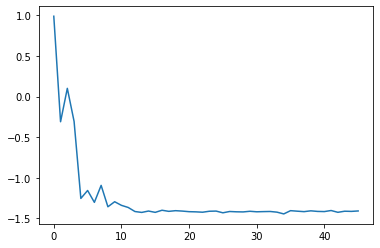

In [10]:
import matplotlib.pyplot as plotter
plotter.plot(exp_values)

In [11]:
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.operators import MatrixOperator, WeightedPauliOperator
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import EfficientSU2

optimizer = COBYLA()
ansatz = RYRZ(num_qubits=2)

Hamiltonian = [ [1,0,0,0],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,-1]]

operator = MatrixOperator(Hamiltonian)
vqe_instance = VQE(operator, var_form=ansatz, optimizer = optimizer)
sv_sim = Aer.get_backend('statevector_simulator')
vqe_instance.run(sv_sim)

{'optimal_parameters': {Parameter(θ[0]): 0.18787357200186935, Parameter(θ[1]): -0.12254440630788077, Parameter(θ[2]): -0.9187330837559416, Parameter(θ[3]): 2.1345173158282713, Parameter(θ[4]): 0.11012765198902451, Parameter(θ[5]): 1.21522715648723, Parameter(θ[6]): -2.2005970486982807, Parameter(θ[7]): 1.7657053144151547, Parameter(θ[8]): 3.046646644084568, Parameter(θ[9]): 0.21881783721514494, Parameter(θ[10]): -1.9868863106876926, Parameter(θ[11]): 2.0604835961372605, Parameter(θ[12]): 0.32897571954137067, Parameter(θ[13]): 1.8714625846903197, Parameter(θ[14]): -2.3952304115801955, Parameter(θ[15]): -0.6473647930746984}, 'optimal_point': array([ 0.18787357, -0.12254441, -0.91873308,  2.13451732,  0.11012765,
        1.21522716, -2.20059705,  1.76570531,  3.04664664,  0.21881784,
       -1.98688631,  2.0604836 ,  0.32897572,  1.87146258, -2.39523041,
       -0.64736479]), 'optimal_value': -0.99999995573579, 'optimizer_evals': 932, 'optimizer_time': 3.474057912826538, 'eigenvalue': (-0